# 說明
- 參考文章：[https://blog.gtwang.org/programming/keras-resnet-50-pre-trained-model-build-dogs-cats-image-classification-system/](https://blog.gtwang.org/programming/keras-resnet-50-pre-trained-model-build-dogs-cats-image-classification-system/)

In [5]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Flatten, Dense, Dropout
from tensorflow.python.keras.applications.resnet50 import ResNet50
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

import os

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

In [6]:
file_path = []
category = []

for d in ['cats', 'dogs']:
    dir_path = 'data/train/' + d
    for file in os.listdir(dir_path):
        file_path.append(dir_path+ '/' + file)
        category.append(file.split('.')[0])

df_train = pd.DataFrame({'file_path': file_path, 'category': category})

df_test = pd.DataFrame({'file_path': os.listdir('data/test')})
df_test['file_path'] = df_test['file_path'].apply(lambda s: 'data/test/'+s)

train, valid = train_test_split(df_train, test_size=0.2)

In [7]:
# 資料路徑
DATASET_PATH  = 'sample'

# 影像大小
IMAGE_SIZE = (224, 224)

# 影像類別數
NUM_CLASSES = 2

# 若 GPU 記憶體不足，可調降 batch size 或凍結更多層網路
BATCH_SIZE = 8

# 凍結網路層數
FREEZE_LAYERS = 2

# Epoch 數
NUM_EPOCHS = 20

# 模型輸出儲存的檔案
WEIGHTS_FINAL = 'model-resnet50-final.h5'

In [10]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=10,
                                   horizontal_flip=True,
                                   fill_mode='nearest')


valid_datagen = ImageDataGenerator(rescale=1./255)


train_batches = train_datagen.flow_from_dataframe(train,
                                                  x_col='file_path', 
                                                  y_col='category',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE)


valid_batches = valid_datagen.flow_from_dataframe(valid,
                                                  x_col='file_path', 
                                                  y_col='category',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE)




test_generator = valid_datagen.flow_from_dataframe(df_test, 
                                                   x_col='file_path', 
                                                   target_size=IMAGE_SIZE, 
                                                   class_mode=None, 
                                                   shuffle=False)

Found 3200 validated image filenames belonging to 2 classes.
Found 800 validated image filenames belonging to 2 classes.
Found 400 validated image filenames.


In [11]:
# 輸出各類別的索引值
for cls, idx in train_batches.class_indices.items():
    print('Class #{} = {}'.format(idx, cls))

Class #0 = cat
Class #1 = dog


In [12]:
# 以訓練好的 ResNet50 為基礎來建立模型，
# 捨棄 ResNet50 頂層的 fully connected layers
net = ResNet50(include_top=False, weights='imagenet', input_tensor=None,
               input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))
x = net.output
x = Flatten()(x)

# 增加 DropOut layer
x = Dropout(0.5)(x)

# 增加 Dense layer，以 softmax 產生個類別的機率值
output_layer = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)

# 設定凍結與要進行訓練的網路層
net_final = Model(inputs=net.input, outputs=output_layer)
for layer in net_final.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in net_final.layers[FREEZE_LAYERS:]:
    layer.trainable = True

# 使用 Adam optimizer，以較低的 learning rate 進行 fine-tuning
net_final.compile(optimizer=Adam(lr=1e-5),
                  loss='categorical_crossentropy', metrics=['accuracy'])

# 輸出整個網路結構
print(net_final.summary())

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\benja\Anaconda3\envs\ml_100_days\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 16s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalizatio

In [13]:
# 訓練模型
net_final.fit_generator(train_batches,
                        steps_per_epoch = train_batches.samples // BATCH_SIZE,
                        validation_data = valid_batches,
                        validation_steps = valid_batches.samples // BATCH_SIZE,
                        epochs = NUM_EPOCHS)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
400/400 [==============================] - 101s 253ms/step - loss: 0.8829 - acc: 0.7369 - val_loss: 2.2925 - val_acc: 0.5138
Epoch 2/20
400/400 [==============================] - 93s 231ms/step - loss: 0.4103 - acc: 0.8778 - val_loss: 0.3482 - val_acc: 0.8963
Epoch 3/20
400/400 [==============================] - 93s 232ms/step - loss: 0.3374 - acc: 0.9072 - val_loss: 0.1321 - val_acc: 0.9650
Epoch 4/20
400/400 [==============================] - 93s 233ms/step - loss: 0.2772 - acc: 0.9275 - val_loss: 0.0762 - val_acc: 0.9750
Epoch 5/20
400/400 [==============================] - 93s 232ms/step - loss: 0.2762 - acc: 0.9241 - val_loss: 0.0913 - val_acc: 0.9725
Epoch 6/20
400/400 [==============================] - 93s 232ms/step - loss: 0.2064 - acc: 0.9378 - val_loss: 0.0715 - val_acc: 0.9775
Epoch 7/20
400/400 [==============================] - 93s 232ms/step - loss: 0.1997 - acc: 0.9447 - val_loss: 0.0743 - val_acc: 0.9775
Epoch 

In [14]:
# 儲存訓練好的模型
net_final.save(WEIGHTS_FINAL)

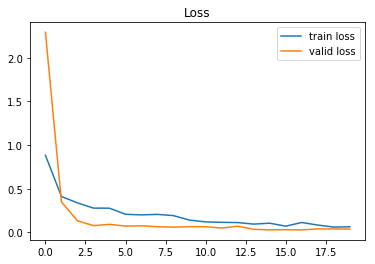

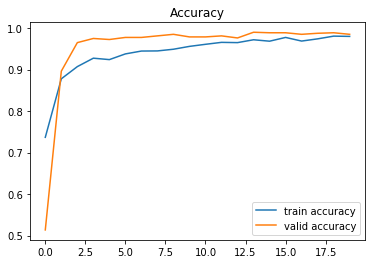

In [16]:
# 檢視訓練過程

train_loss = net_final.history.history["loss"]
valid_loss = net_final.history.history["val_loss"]
train_acc = net_final.history.history["acc"]
valid_acc = net_final.history.history["val_acc"]

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

100/100 [==============================] - 6s 61ms/step


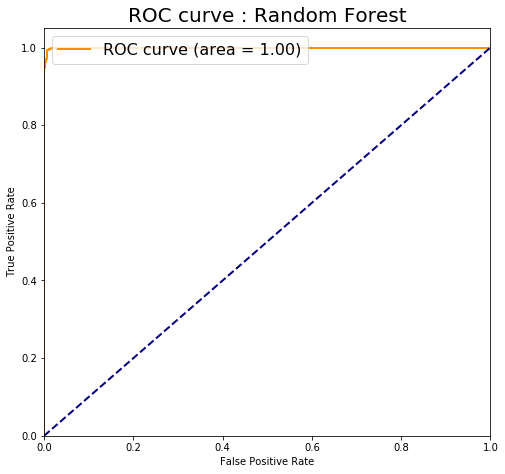

In [20]:
# 檢視AUC

valid_batches.reset()
valid_pred = net_final.predict_generator(valid_batches, verbose=1, steps=len(valid_batches))

y_true = valid['category'].apply(lambda c: 1 if c=='cat' else 0)
y_pred_prob = valid_pred[:,0]

fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob, pos_label=1)

plt.figure(figsize=(8,7.5))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = {0:.2f})'.format(auc(fpr, tpr)))
plt.plot([0,1], [0,1], color='navy', lw=lw, linestyle='--')
plt.xlim(0,1)
plt.ylim(0,1.05)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve : Random Forest', fontsize=20)
plt.legend(loc='upper left', fontsize=16)

plt.show()

In [21]:
# 預測test data

test_generator.reset()
prediction_probabilities = net_final.predict_generator(test_generator, verbose=1, steps=len(test_generator))

13/13 [==============================] - 4s 272ms/step


In [22]:
pic_id = df_test['file_path'].apply(lambda s: s[10:13])
solution = pd.DataFrame({"ID": pic_id, "Predicted":prediction_probabilities[:, 0]})

solution.head()

,ID,Predicted
0,000,1.000000e+00
1,001,4.558196e-09
2,002,1.000000e+00
3,003,1.990209e-16
4,004,1.000000e+00


In [23]:
solution.to_csv('submission_trnas_resnet50_0817.csv', index=False)